In [1]:
import matplotlib.pyplot as plt
import numpy as np

# DEFINICION DE INTEGRADOR TEMPORAL
def RK4_FD(eq, fields, parameters, grids, dt, Nt, operators, t_rate): #implementa rouge-kutta
    t_grid = grids[0]
    x_grid = grids[1]
    y_grid = grids[2]
    fields_history = []
    time_grid = []
    for i in range(Nt - 1):
        old_fields = fields
        k_1 = equations_FD(eq, old_fields, t_grid[i], x_grid, y_grid, parameters, operators)
        k_2 = equations_FD(eq, old_fields + 0.5 * dt * k_1, t_grid[i], x_grid, y_grid, parameters, operators)
        k_3 = equations_FD(eq, old_fields + 0.5 * dt * k_2, t_grid[i], x_grid, y_grid, parameters, operators)
        k_4 = equations_FD(eq, old_fields + dt * k_3, t_grid[i], x_grid, y_grid, parameters, operators)
        new_fields = old_fields + dt * (k_1 + 2 * k_2 + 2 * k_3 + k_4) / 6
        fields = new_fields
        if i % t_rate == 0:
            fields_history.append(fields)
            time_grid.append(t_grid[i])
    return fields, fields_history, time_grid

# DEFINICION DE SISTEMA DE ECUACIONES
def equations_FD(eq, field_slices, t_i, x_grid, y_grid, parameters, operators): #ecuaciones
    if eq == "PT_waveguide":
        U = field_slices[0]
        V = field_slices[1]

        k = parameters[0]
        gamma = parameters[1]
        alpha = parameters[2]

        #F = 1j * ((k - 1j * alpha) * V - gamma * (U / (1 + np.abs(U) ** 2)))
        #G = 1j * ((k + 1j * alpha) * U - gamma * (V / (1 + np.abs(V) ** 2)))

        F = 1j * (k * V - gamma * (U / (1 + np.abs(U) ** 2)) - 1j * alpha * U)
        G = 1j * (k * U - gamma * (V / (1 + np.abs(V) ** 2)) + 1j * alpha * V)

        fields = np.array([F, G])
    return fields

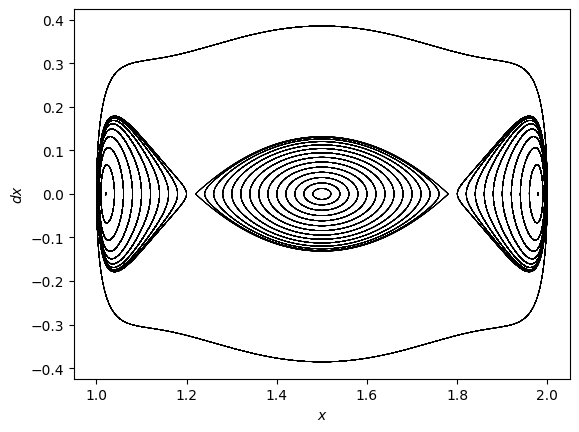

In [4]:
# DEFINICIONES PRELIMINARES
eq = "PT_waveguide"
t_rate = 1

# PARAMETROS (GAMMA = POTENCIAL, K = ACOPLE, ALPHA = GAIN - LOSS)

gamma = 10
k = 1.0
alpha = 0.0

# DEFINICIÓN DE GRILLA TEMPORAL, ESPACIAL SE DEFINE COMO ARRAY CERO POR COMO FUNCIONA EL CODIGO
[tmin, tmax, dt] = [0, 100, 0.025]
t_grid = np.arange(tmin, tmax + dt, dt)         # TEMPORAL GRID DEFINITION
x_grid = np.array([0])           # SPATIAL GRID DEFINITION
T = tmax
Nt = t_grid.shape[0]
Xs = np.arange(0.00, 1.00, 0.02)
for x in Xs:
    # PARAMETROS INICIALES (P = CANTIDAD CONSERVADA, X = PORCENTAJE DE INFORMACIÓN INICIAL EN DIMERO 2)

    P = 18                  # (Vicencio & Clerc) FIG 1A, B, C, D: P = 0.1, 10, 18, 30

    # CONDICIONES INICIALES EN TERMINOS DE P Y X
    U_init = np.sqrt(P * (1 - x))
    V_init = np.sqrt(P * x)

    # EMPAQUETAMIENTO DE PARAMETROS PARA SIMULACIÓN
    operators = [0]
    fields_init = [U_init, V_init]
    grids = [t_grid, x_grid, 0]
    parameters_np = np.array([k, gamma, alpha])

    # SIMULACIÓN NUMERICA
    final_fields, fields_history, time_grid = RK4_FD(eq, fields_init, parameters_np, grids, dt, Nt, operators, t_rate)      #NUMERICAL SIMULATION

    # REOBTENIENDO DATOS DE SIMULACIÓN
    U = np.array(fields_history)[:, 0]
    V = np.array(fields_history)[:, 1]
    lightness = 1
    U_light = U[0::lightness]
    V_light = V[0::lightness]
    t_light = np.array(time_grid[0::lightness])
    dx = -2 * np.imag(U_light * np.conjugate(V_light)) / P
    P1 = np.abs(U_light) ** 2
    P2 = np.abs(V_light) ** 2
    x_ne = P2 / P
    x_dyn = 1 + x_ne
    plt.plot(x_dyn, dx, color="k", lw=0.5)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$dx$")
plt.show()

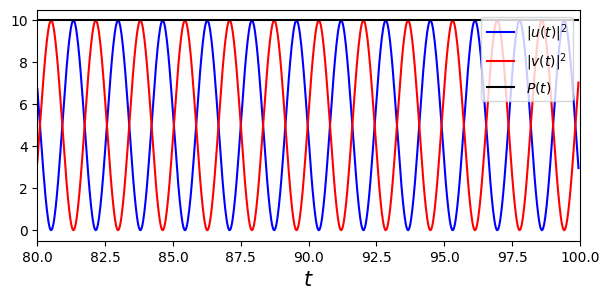

In [58]:
############### GENERIC INITIAL AND FINAL TIME ###############
t_init = 80
t_final = 100
i_0 = np.argmin(np.abs(t_light - t_init))
i_f = np.argmin(np.abs(t_light - t_final))

############### GRAFICO DE P1, P2 Y P EN EL TIEMPO ###############

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(t_light[i_0:i_f], P1[i_0:i_f], color='b', label="$|u(t)|^2$")
ax.plot(t_light[i_0:i_f], P2[i_0:i_f], color='r', label="$|v(t)|^2$")
ax.plot(t_light[i_0:i_f], P1[i_0:i_f] + P2[i_0:i_f], color='k', label="$P(t)$")
ax.legend(fontsize=10, loc="upper right")
ax.set_xlabel("$t$", fontsize=15)
ax.set_xlim(t_init, t_final)
plt.show()

# REPRODUCE RESULTADOS DE FIG. 4 VICENCIO + CLERC